In [ ]:
!pip install tensorflow
!pip install ta
!pip install yfinance

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=f0213cd9da58a83f77a37737ceab547929fa5597886b64251da5387eade1fb55
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf
import matplotlib.pyplot as plt
import ta



In [ ]:
"""
# Función de pérdida personalizada
Se define una función de pérdida llamada huber_loss, que es una combinación de la pérdida cuadrática (para errores pequeños) y la pérdida lineal (para errores grandes).
Esta función se usa en problemas de regresión para ser más robusta ante valores atípicos (outliers).
La función clasifica los errores (diferencia entre predicción y valor real) en dos categorías: errores pequeños y errores grandes, usando un umbral (delta).
####Para errores pequeños: Se usa la pérdida cuadrática (MSE) para asegurar un ajuste fino.
####Para errores grandes: Se usa una pérdida lineal para reducir el impacto de outliers.
Esta función es útil cuando se tiene una combinación de errores pequeños y grandes en los datos, proporcionando un buen balance entre sensibilidad y robustez.
"""
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    big_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, big_error_loss)
"""
# Obtener datos históricos de BTC
Se descargan datos históricos del Bitcoin (BTC-USD) desde Yahoo Finance, entre las fechas especificadas (del 1 de enero de 2015 al 31 de mayo de 2023).
Se extraen las columnas más relevantes para el análisis: Close, Volume, High, Low (Precio de cierre, Volumen de operaciones, Precio máximo y mínimo).
"""
btc_data = yf.download('BTC-USD', start='2015-01-01', end='2023-05-31')

"""
###Procesamiento y Preparación de los Datos:
Los datos descargados son transformados en un DataFrame y se establece la columna Date como índice, lo que facilita trabajar con datos de series temporales.
Se calculan varios indicadores técnicos que son comúnmente usados para analizar el comportamiento de los precios:
Media Móvil de 7 días (MA7): Promedio de los precios de cierre de los últimos 7 días. Este indicador suaviza los datos y ayuda a identificar la tendencia a corto plazo.
Media Móvil de 30 días (MA30): Similar al anterior, pero con una ventana de 30 días para capturar tendencias más largas.
Índice de Fuerza Relativa (RSI): Indicador de momentum que mide la velocidad y el cambio de los movimientos de precios. Este indicador oscila entre 0 y 100 y ayuda a identificar si un activo está sobrecomprado o sobrevendido.
MACD (Moving Average Convergence Divergence): Otro indicador de tendencia que muestra la relación entre dos medias móviles de precios. Es útil para identificar cambios en la fuerza, dirección y duración de una tendencia.
"""
df = btc_data[['Close', 'Volume', 'High', 'Low']].reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Agregar indicadores técnicos
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA30'] = df['Close'].rolling(window=30).mean()

# Índice de Fuerza Relativa (RSI)
# Asegúrate de que 'Close' sea un array unidimensional (.squeeze() elimina cualquier dimensión adicional)
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'].squeeze(), window=14).rsi()

# Divergencia Convergencia Media (MACD)
df['MACD'] = ta.trend.MACD(df['Close'].squeeze()).macd()


# Eliminar filas con valores NaN impieza de Datos:
#Después de calcular los indicadores, se eliminan las filas con valores NaN, que pueden aparecer debido a la naturaleza de los cálculos
#de los indicadores (por ejemplo, las primeras filas no tienen suficientes datos históricos para calcular la media móvil o el RSI).
df = df.dropna()
"""
Normalización de los Datos:
Se utiliza MinMaxScaler de Scikit-learn para escalar todas las columnas seleccionadas (Close, Volume, High, Low, MA7, MA30, RSI, MACD) entre 0 y 1.
Esto es esencial para que los algoritmos de machine learning que se aplicarán posteriormente (como redes neuronales) puedan converger más rápido y funcionar de manera eficiente.
Esta normalización asegura que ninguna característica domine a las demás en términos de magnitud, lo cual es especialmente importante para modelos sensibles a los rangos de entrada.
"""
scaler = MinMaxScaler()

# Ajustar y transformar los datos para escalarlos entre 0 y 1
# Solo selecciona las columnas que necesitas para el escalado
scaled_data = scaler.fit_transform(df[['Close', 'Volume', 'High', 'Low', 'MA7', 'MA30', 'RSI', 'MACD']])

# Transformación completa
print(scaled_data)

[*********************100%***********************]  1 of 1 completed

[[2.36503491e-04 4.56018386e-05 3.06907697e-04 ... 3.88491342e-04
  3.80725265e-01 4.88464183e-01]
 [1.03464798e-04 3.63215084e-05 1.70590101e-04 ... 3.36927875e-04
  3.51082698e-01 4.88359221e-01]
 [2.44624436e-04 5.27916013e-05 1.42442892e-04 ... 2.90012752e-04
  3.96683361e-01 4.88361408e-01]
 ...
 [4.13846036e-01 4.14142319e-02 4.07941262e-01 ... 4.37698070e-01
  5.56759377e-01 4.63207826e-01]
 [4.08801793e-01 4.32266442e-02 4.11420881e-01 ... 4.36897539e-01
  5.15212488e-01 4.70246814e-01]
 [4.08155452e-01 3.77267531e-02 4.05772760e-01 ... 4.36062988e-01
  5.09877982e-01 4.75642789e-01]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0065 - val_loss: 6.5253e-04
Epoch 2/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 2.6969e-04
Epoch 3/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.0990e-04 - val_loss: 3.7741e-04
Epoch 4/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.1321e-04 - val_loss: 2.3125e-04
Epoch 5/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.6469e-04 - val_loss: 2.7103e-04
Epoch 6/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7639e-04 - val_loss: 8.1294e-04
Epoch 7/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.6755e-04 - val_loss: 5.2511e-04
Epoch 8/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.4022e-04 - val_loss: 1.7829e-04
Epoch 9/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6761e-04 - val_loss: 6.7518e-04
Epoch 10/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9211e-04 - val_loss: 1.6956e-04
Epoch 11/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.8569e-04 -

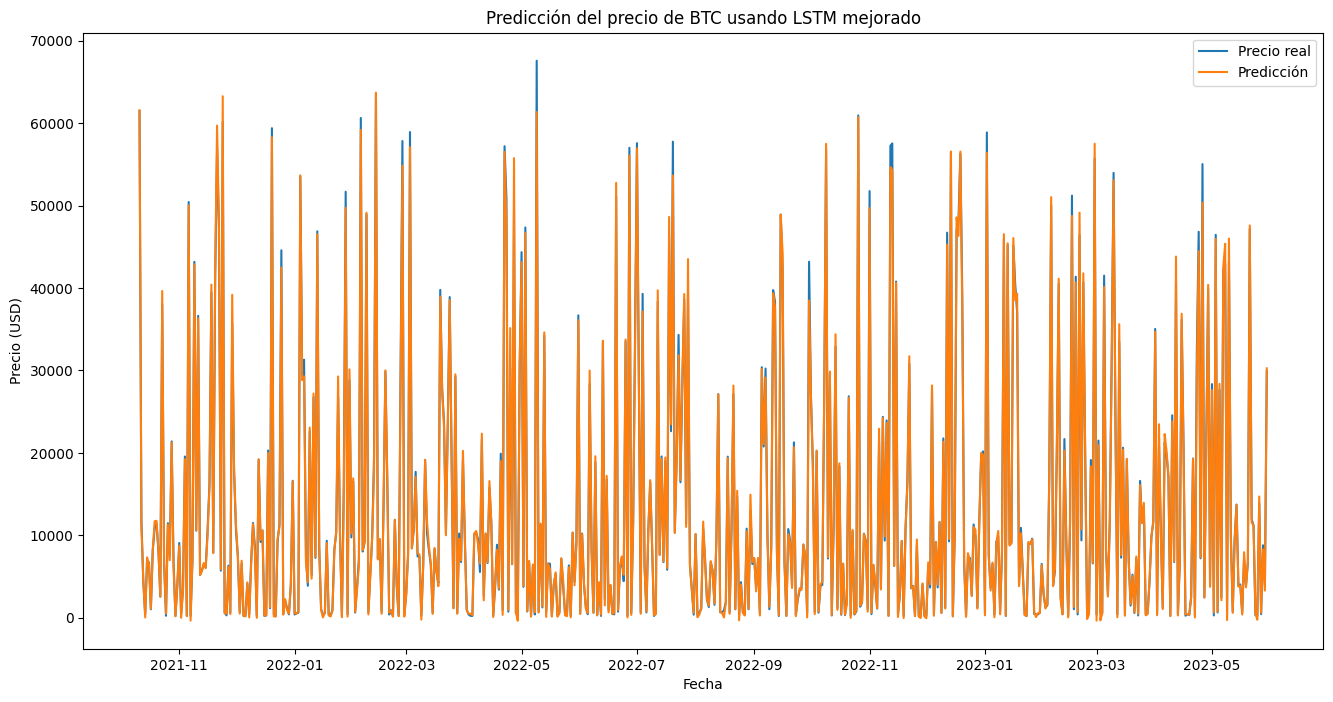

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicción del precio de BTC para el próximo día: $28278.49


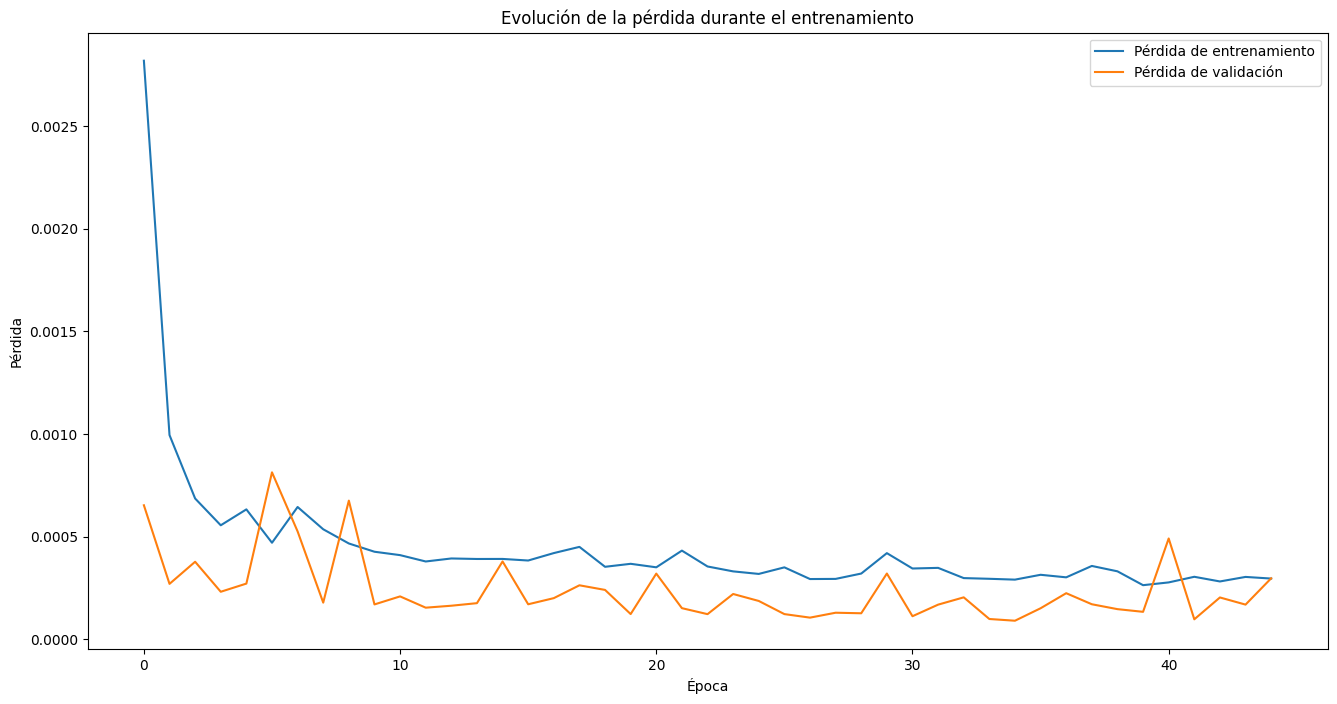

'\nImportar TensorFlow: Asegúrate de que TensorFlow está importado al principio de tu script. Puedes hacerlo añadiendo la siguiente línea:\n\npython\nCopiar código\nimport tensorflow as tf\nDefinición de la función huber_loss: Asegúrate de que la función huber_loss está definida correctamente. Aquí tienes una implementación de ejemplo:\n\npython\nCopiar código\ndef huber_loss(y_true, y_pred, delta=1.0):\n    error = y_true - y_pred\n    is_small_error = tf.abs(error) <= delta\n    small_error_loss = 0.5 * tf.square(error)\n    big_error_loss = delta * (tf.abs(error) - 0.5 * delta)\n    return tf.where(is_small_error, small_error_loss, big_error_loss)\nCódigo completo: Aquí tienes cómo se verá tu código con estas correcciones:\n\npython\nCopiar código\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport tensorflow as tf  # Importa TensorFlow\nfrom keras.models import Sequential\nfrom keras.layers import LSTM, Dense, Dropout\nfrom sklearn.model_selection import train_test_split\n

In [ ]:
# Esta función prepara las secuencias de datos para ser utilizadas en el modelo LSTM.
# Recibe como parámetros los datos escalados y el número de pasos temporales.
def crear_secuencias(data, time_steps):
    X, y = [], []  # Inicializa listas vacías para almacenar las secuencias de entrada (X) y salida (y).
    for i in range(len(data) - time_steps):  # Itera sobre los datos, excluyendo los últimos 'time_steps' elementos.
        X.append(data[i:(i + time_steps), :])  # Añade una secuencia de 'time_steps' elementos a la lista X.
        y.append(data[i + time_steps, 0])  # Añade el elemento siguiente a la secuencia como etiqueta (salida).
    return np.array(X), np.array(y)  # Retorna las listas convertidas en arrays numpy.


time_steps = 60  # Establece el número de pasos temporales para las secuencias.
X, y = crear_secuencias(scaled_data, time_steps)  # Llama a la función para crear las secuencias.

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

"""from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout  # Asegúrate de importar las capas adecuadas.
"""
# Crear y entrenar el modelo LSTM mejorado
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_steps, X.shape[2])),  # Usar LSTM aquí
    Dropout(0.2),
    LSTM(100),  # No necesitas 'return_sequences' aquí
    Dropout(0.2),
    Dense(50),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=huber_loss)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=200,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Hacer predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir las predicciones a la escala original
train_predict = scaler.inverse_transform(np.hstack([train_predict, np.zeros((train_predict.shape[0], X.shape[2]-1))]))[:, 0]
test_predict = scaler.inverse_transform(np.hstack([test_predict, np.zeros((test_predict.shape[0], X.shape[2]-1))]))[:, 0]
y_train_inv = scaler.inverse_transform(np.hstack([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], X.shape[2]-1))]))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X.shape[2]-1))]))[:, 0]

# Calcular el error cuadrático medio (RMSE)
train_rmse = np.sqrt(np.mean((train_predict - y_train_inv)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test_inv)**2))

print(f"RMSE en entrenamiento: {train_rmse}")
print(f"RMSE en prueba: {test_rmse}")

# Visualizar los resultados
plt.figure(figsize=(16,8))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Precio real')
plt.plot(df.index[-len(y_test):], test_predict, label='Predicción')
plt.title('Predicción del precio de BTC usando LSTM mejorado')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

# Hacer una predicción para el próximo día
ultimo_60_dias = scaled_data[-60:]
X_siguiente = np.array([ultimo_60_dias])
prediccion_siguiente = model.predict(X_siguiente)
prediccion_siguiente = scaler.inverse_transform(np.hstack([prediccion_siguiente, np.zeros((prediccion_siguiente.shape[0], X.shape[2]-1))]))[:, 0]

print(f"Predicción del precio de BTC para el próximo día: ${prediccion_siguiente[0]:.2f}")

# Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
"""
Importar TensorFlow: Asegúrate de que TensorFlow está importado al principio de tu script. Puedes hacerlo añadiendo la siguiente línea:

python
Copiar código
import tensorflow as tf
Definición de la función huber_loss: Asegúrate de que la función huber_loss está definida correctamente. Aquí tienes una implementación de ejemplo:

python
Copiar código
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    big_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, big_error_loss)
Código completo: Aquí tienes cómo se verá tu código con estas correcciones:

python
Copiar código
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  # Importa TensorFlow
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Función para crear secuencias
def crear_secuencias(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 60
X, y = crear_secuencias(scaled_data, time_steps)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo LSTM
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_steps, X.shape[2])),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])

def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    big_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, big_error_loss)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=huber_loss)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=200,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Hacer predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir las predicciones a la escala original
train_predict = scaler.inverse_transform(np.hstack([train_predict, np.zeros((train_predict.shape[0], X.shape[2]-1))]))[:, 0]
test_predict = scaler.inverse_transform(np.hstack([test_predict, np.zeros((test_predict.shape[0], X.shape[2]-1))]))[:, 0]
y_train_inv = scaler.inverse_transform(np.hstack([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], X.shape[2]-1))]))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X.shape[2]-1))]))[:, 0]

# Calcular el error cuadrático medio (RMSE)
train_rmse = np.sqrt(np.mean((train_predict - y_train_inv)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test_inv)**2))

print(f"RMSE en entrenamiento: {train_rmse}")
print(f"RMSE en prueba: {test_rmse}")

# Visualizar los resultados
plt.figure(figsize=(16,8))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Precio real')
plt.plot(df.index[-len(y_test):], test_predict, label='Predicción')
plt.title('Predicción del precio de BTC usando LSTM mejorado')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

# Hacer una predicción para el próximo día
ultimo_60_dias = scaled_data[-60:]
X_siguiente = np.array([ultimo_60_dias])
prediccion_siguiente = model.predict(X_siguiente)
prediccion_siguiente = scaler.inverse_transform(np.hstack([prediccion_siguiente, np.zeros((prediccion_siguiente.shape[0], X.shape[2]-1))]))[:, 0]

print(f"Predicción del precio de BTC para el próximo día: ${prediccion_siguiente[0]:.2f}")

# Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
"""

In [ ]:
"""Al evaluar tus estrategias, es crucial considerar la calidad de los datos, el costo de transacción, la liquidez y otros factores del mercado que puedan afectar el rendimiento de tus estrategias. Además, siempre es recomendable realizar una validación cruzada y pruebas en diferentes entornos de mercado para asegurarte de que tu estrategia sea robusta y adaptable a diversas condiciones.
"""

In [ ]:
# Imprimir el último día con el que se ha entrenado el modelo
ultimo_dia = df.index[-1]  # Accede al último índice (fecha) del DataFrame
print("Último día con el que se ha entrenado el modelo:", ultimo_dia)

Último día con el que se ha entrenado el modelo: 2023-05-30 00:00:00+00:00


In [ ]:
#guardar modelo en formato keras
from keras.saving import save_model
save_model(model, "lstm_model.keras")


In [ ]:
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 100)        │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,305 (1.48 MB)

 Trainable params: 129,101 (504.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 258,204 (1008.61 KB)

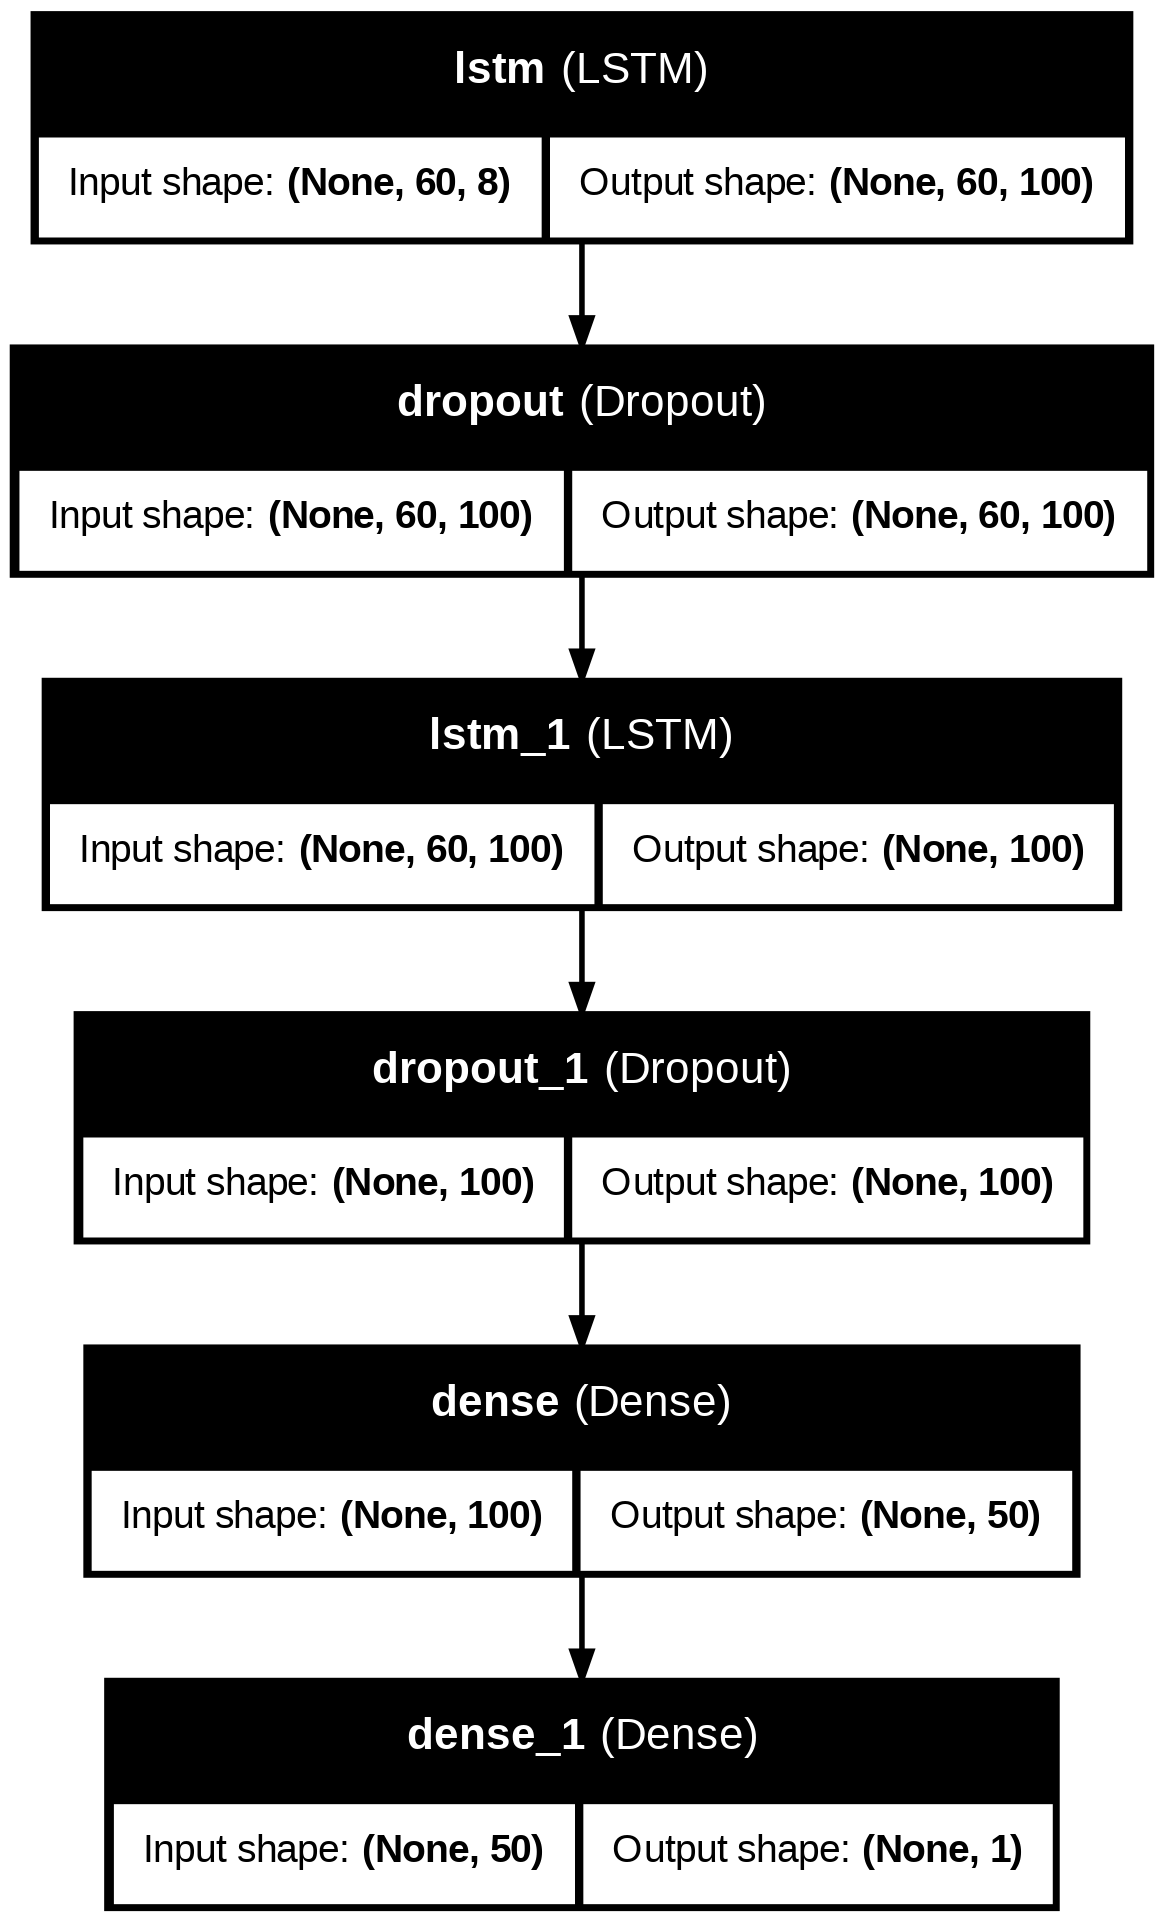

In [ ]:
from tensorflow.keras.utils import plot_model

# Guardar el gráfico de la arquitectura del modelo
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0064 - val_loss: 5.0591e-04
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 3.9446e-04
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.4141e-04 - val_loss: 7.5589e-04
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.4118e-04 - val_loss: 3.4338e-04
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.0345e-04 - val_loss: 4.4071e-04
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.7067e-04 - val_loss: 7.1164e-04
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.0306e-04 - val_loss: 3.1350e-04
Epoch 8/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2545e-04 - val_loss: 3.8315e-04
Epoch 9/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.1793e-04 - val_loss: 2.9151e-04
Epoch 10/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.3343e-04 - val_loss: 2.8536e-04
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE 

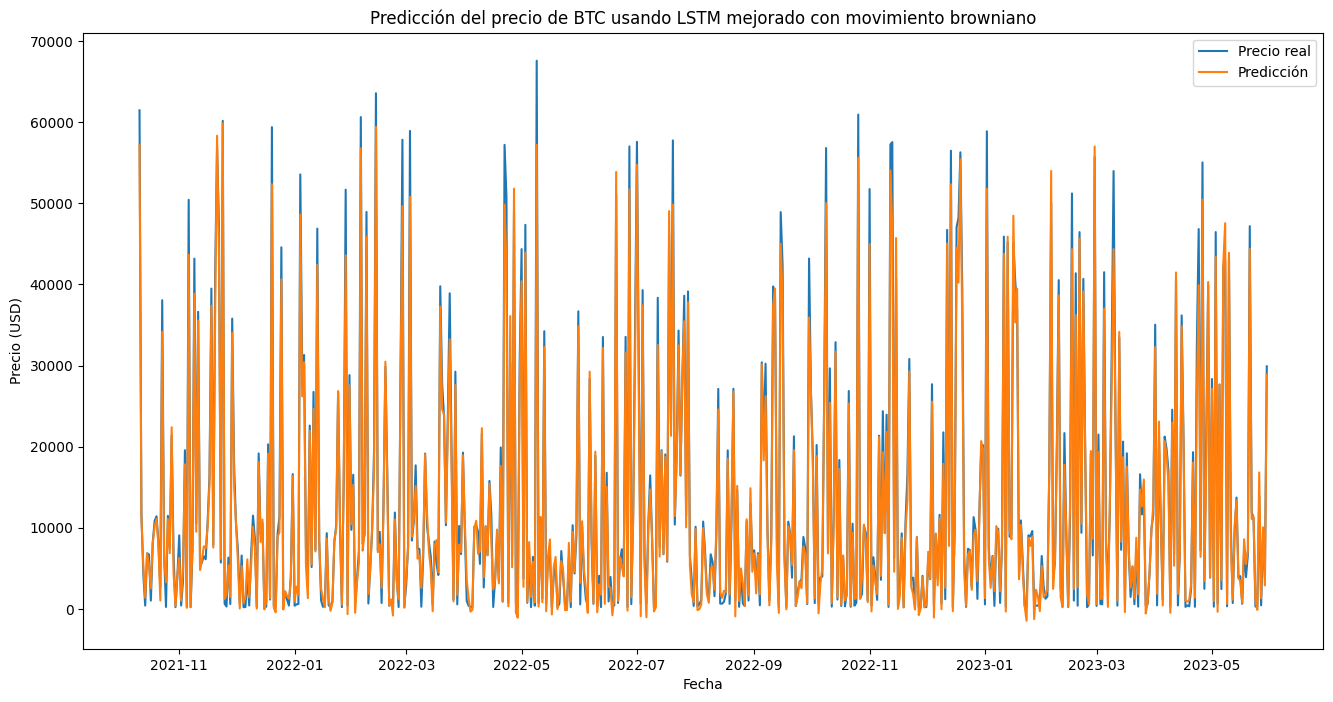

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicción del precio de BTC para el próximo día: $26913.81


In [ ]:

# Función de pérdida personalizada
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    big_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, big_error_loss)

# Cargar el modelo LSTM entrenado
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_steps, X.shape[2])),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=huber_loss)

# Agregar el movimiento browniano a la entrada del modelo
def add_brownian_noise(X):
    brownian_noise = tf.random.normal(tf.shape(X), mean=0.0, stddev=0.1, dtype=tf.float32)
    return X + brownian_noise

X_train_noise = add_brownian_noise(X_train)
X_test_noise = add_brownian_noise(X_test)

# Entrenar el modelo con el ruido browniano
history = model.fit(
    X_train_noise, y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_test_noise, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Hacer predicciones con el modelo entrenado
train_predict = model.predict(X_train_noise)
test_predict = model.predict(X_test_noise)

# Invertir las predicciones a la escala original
train_predict = scaler.inverse_transform(np.hstack([train_predict, np.zeros((train_predict.shape[0], X.shape[2]-1))]))[:, 0]
test_predict = scaler.inverse_transform(np.hstack([test_predict, np.zeros((test_predict.shape[0], X.shape[2]-1))]))[:, 0]
y_train_inv = scaler.inverse_transform(np.hstack([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], X.shape[2]-1))]))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X.shape[2]-1))]))[:, 0]

# Calcular el error cuadrático medio (RMSE)
train_rmse = np.sqrt(np.mean((train_predict - y_train_inv)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test_inv)**2))

print(f"RMSE en entrenamiento: {train_rmse}")
print(f"RMSE en prueba: {test_rmse}")

# Visualizar los resultados
plt.figure(figsize=(16,8))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Precio real')
plt.plot(df.index[-len(y_test):], test_predict, label='Predicción')
plt.title('Predicción del precio de BTC usando LSTM mejorado con movimiento browniano')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

# Hacer una predicción para el próximo día
ultimo_60_dias = scaled_data[-60:]
X_siguiente = np.array([ultimo_60_dias])
X_siguiente_noise = add_brownian_noise(X_siguiente)
prediccion_siguiente = model.predict(X_siguiente_noise)
prediccion_siguiente = scaler.inverse_transform(np.hstack([prediccion_siguiente, np.zeros((prediccion_siguiente.shape[0], X.shape[2]-1))]))[:, 0]

print(f"Predicción del precio de BTC para el próximo día: ${prediccion_siguiente[0]:.2f}")

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf
import matplotlib.pyplot as plt
import ta

# Función de pérdida personalizada
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    big_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, big_error_loss)

# Obtener datos históricos de BTC (desde 2022)
btc_data = yf.download('BTC-USD', start='2022-01-01', end='2024-10-28')

df = btc_data[['Close', 'Volume', 'High', 'Low']].reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Agregar indicadores técnicos
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA30'] = df['Close'].rolling(window=30).mean()
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'].squeeze(), window=14).rsi()
df['MACD'] = ta.trend.MACD(df['Close'].squeeze()).macd()

# Eliminar filas con valores NaN
df = df.dropna()

# Normalizar los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close', 'Volume', 'High', 'Low', 'MA7', 'MA30', 'RSI', 'MACD']])

# Crear secuencias de datos
time_steps = 60
X, y = crear_secuencias(scaled_data, time_steps)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo LSTM mejorado
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_steps, X.shape[2])),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=huber_loss)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=200,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Hacer predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir las predicciones a la escala original
train_predict = scaler.inverse_transform(np.hstack([train_predict, np.zeros((train_predict.shape[0], X.shape[2]-1))]))[:, 0]
test_predict = scaler.inverse_transform(np.hstack([test_predict, np.zeros((test_predict.shape[0], X.shape[2]-1))]))[:, 0]
y_train_inv = scaler.inverse_transform(np.hstack([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], X.shape[2]-1))]))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X.shape[2]-1))]))[:, 0]

# Calcular el error cuadrático medio (RMSE)
train_rmse = np.sqrt(np.mean((train_predict - y_train_inv)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test_inv)**2))

print(f"RMSE en entrenamiento: {train_rmse}")
print(f"RMSE en prueba: {test_rmse}")

# Visualizar los resultados
plt.figure(figsize=(16,8))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Precio real')
plt.plot(df.index[-len(y_test):], test_predict, label='Predicción')
plt.title('Predicción del precio de BTC usando LSTM mejorado')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

# Hacer una predicción para el próximo día
ultimo_60_dias = scaled_data[-60:]
X_siguiente = np.array([ultimo_60_dias])
prediccion_siguiente = model.predict(X_siguiente)
prediccion_siguiente = scaler.inverse_transform(np.hstack([prediccion_siguiente, np.zeros((prediccion_siguiente.shape[0], X.shape[2]-1))]))[:, 0]

print(f"Predicción del precio de BTC para el próximo día: ${prediccion_siguiente[0]:.2f}")

# Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Guardar el modelo
from tensorflow.keras.saving import save_model
save_model(model, "lstm_model.keras")

"""
# Subir el modelo a Hugging Face
from huggingface_hub import HfApi, login
login(token='hf_xXfgydIUiLUEknXuuFhgMqZP')
api = HfApi()
repo_id = "weoweke23/lstm_model"
model_path = "lstm_model.keras"
api.create_repo(repo_id=repo_id, repo_type="model", exist_ok=True)
api.upload_file(path_or_fileobj=model_path, path_in_repo="lstm_model.keras", repo_id=repo_id, repo_type="model")
print("Modelo subido correctamente.")"""

ModuleNotFoundError: No module named 'ta'

[*********************100%***********************]  1 of 1 completed


Pérdida en el conjunto de prueba: 0.00015165749937295914

Características del modelo:
Número de capas: 6


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 60, 100)             │          43,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 387,305 (1.48 MB)

 Trainable params: 129,101 (504.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 258,204 (1008.61 KB)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Tasa de acierto (MAE): 0.013006354949093553


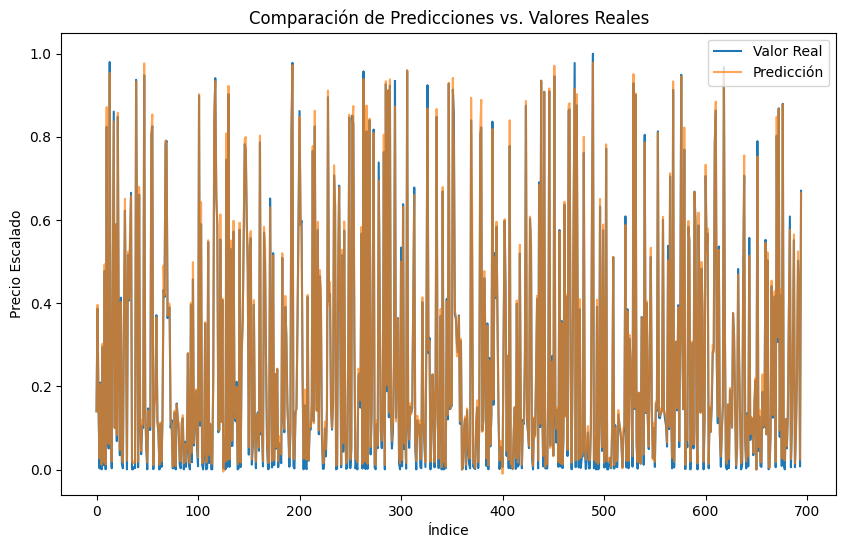

In [ ]:
# Importar las bibliotecas necesarias
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

# Cargar el modelo con la función de pérdida personalizada huber_loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    big_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, big_error_loss)

# Ruta al modelo guardado
model_path = "lstm_model.keras"
model = tf.keras.models.load_model(model_path, custom_objects={'huber_loss': huber_loss})

# Obtener datos de prueba (históricos de BTC)
btc_data = yf.download('BTC-USD', start='2015-01-01', end='2024-09-30')
df = btc_data[['Close', 'Volume', 'High', 'Low']].reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Agregar indicadores técnicos
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA30'] = df['Close'].rolling(window=30).mean()
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'].squeeze(), window=14).rsi()
df['MACD'] = ta.trend.MACD(df['Close'].squeeze()).macd()

# Limpiar datos NaN
df = df.dropna()

# Normalización de los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close', 'Volume', 'High', 'Low', 'MA7', 'MA30', 'RSI', 'MACD']])

# Crear secuencias de datos
def crear_secuencias(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 60
X, y = crear_secuencias(scaled_data, time_steps)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluar el modelo en el conjunto de datos de prueba
result = model.evaluate(X_test, y_test, verbose=0)
print("Pérdida en el conjunto de prueba:", result)

# Características del modelo
print("\nCaracterísticas del modelo:")
print("Número de capas:", len(model.layers))
model.summary()

# Predicciones y tasa de acierto
y_pred = model.predict(X_test)
tasa_acierto = mean_absolute_error(y_test, y_pred)
print("Tasa de acierto (MAE):", tasa_acierto)

# Visualización de la tasa de acierto
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valor Real')
plt.plot(y_pred, label='Predicción', alpha=0.7)
plt.title("Comparación de Predicciones vs. Valores Reales")
plt.xlabel("Índice")
plt.ylabel("Precio Escalado")
plt.legend()
plt.show()


In [ ]:

!pip install backtrader


In [ ]:
import backtrader as bt
import yfinance as yf
import pandas as pd
import tensorflow as tf
import numpy as np
from datetime import datetime

# 1. Descargar datos de Yahoo Finance
data = yf.download("BTC-USD", start="2023-01-01", end="2024-10-01")

# 2. Ajustar el índice y las columnas para compatibilidad con Backtrader
data.index = pd.to_datetime(data.index)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Orden correcto de columnas
data.columns = ['open', 'high', 'low', 'close', 'volume']  # Minúsculas, como espera Backtrader

# 3. Crear la clase de estrategia
class MLTradingStrategy(bt.Strategy):
    def __init__(self):
        # Cargar el modelo previamente entrenado
        self.model = tf.keras.models.load_model("lstm_model.keras")
        self.data_points = []  # Almacena datos históricos para predicciones

    def next(self):
        # Añadir el precio de cierre actual a los datos históricos
        self.data_points.append([self.data.close[0]])

        # Mantener la longitud de los datos históricos acorde a los requisitos de entrada del modelo
        if len(self.data_points) >= 60:
            input_data = np.array(self.data_points[-60:]).reshape(1, 60, 1)
            prediction = self.model.predict(input_data)

            # Lógica de compra y venta en función de la predicción
            if prediction > 0:
                self.buy()  # Señal de compra
            elif prediction < 0:
                self.sell()  # Señal de venta

# 4. Convertir DataFrame a un formato compatible con Backtrader
bt_data = bt.feeds.PandasData(dataname=data)

# 5. Configurar Backtrader
cerebro = bt.Cerebro()
cerebro.addstrategy(MLTradingStrategy)
cerebro.adddata(bt_data)

# 6. Ejecutar backtesting
cerebro.run()

# 7. Visualizar resultados
cerebro.plot()


[*********************100%***********************]  1 of 1 completed


TypeError: Could not locate function 'huber_loss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'huber_loss', 'registered_name': 'function'}

In [ ]:
!pip install tensorflow==2.12.0 #Downgrade tensorflow to 2.12.0

import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import ta  # Asegúrate de que la biblioteca 'ta' esté instalada
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Downgrade tensorflow to 2.

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    U

[*********************100%***********************]  1 of 1 completed


Epoch 1/200
78/78 [==============================] - 24s 173ms/step - loss: 0.0027 - val_loss: 4.1135e-04
Epoch 2/200
78/78 [==============================] - 7s 85ms/step - loss: 9.9607e-04 - val_loss: 5.9124e-04
Epoch 3/200
78/78 [==============================] - 8s 104ms/step - loss: 6.6831e-04 - val_loss: 3.2826e-04
Epoch 4/200
78/78 [==============================] - 8s 102ms/step - loss: 5.8743e-04 - val_loss: 2.1343e-04
Epoch 5/200
78/78 [==============================] - 8s 101ms/step - loss: 7.1330e-04 - val_loss: 2.1467e-04
Epoch 6/200
78/78 [==============================] - 7s 93ms/step - loss: 6.3323e-04 - val_loss: 2.1305e-04
Epoch 7/200
78/78 [==============================] - 7s 95ms/step - loss: 4.6953e-04 - val_loss: 1.9595e-04
Epoch 8/200
78/78 [==============================] - 8s 106ms/step - loss: 4.9212e-04 - val_loss: 1.8727e-04
Epoch 9/200
78/78 [==============================] - 7s 86ms/step - loss: 5.8836e-04 - val_loss: 5.0363e-04
Epoch 10/200
78/78 [======

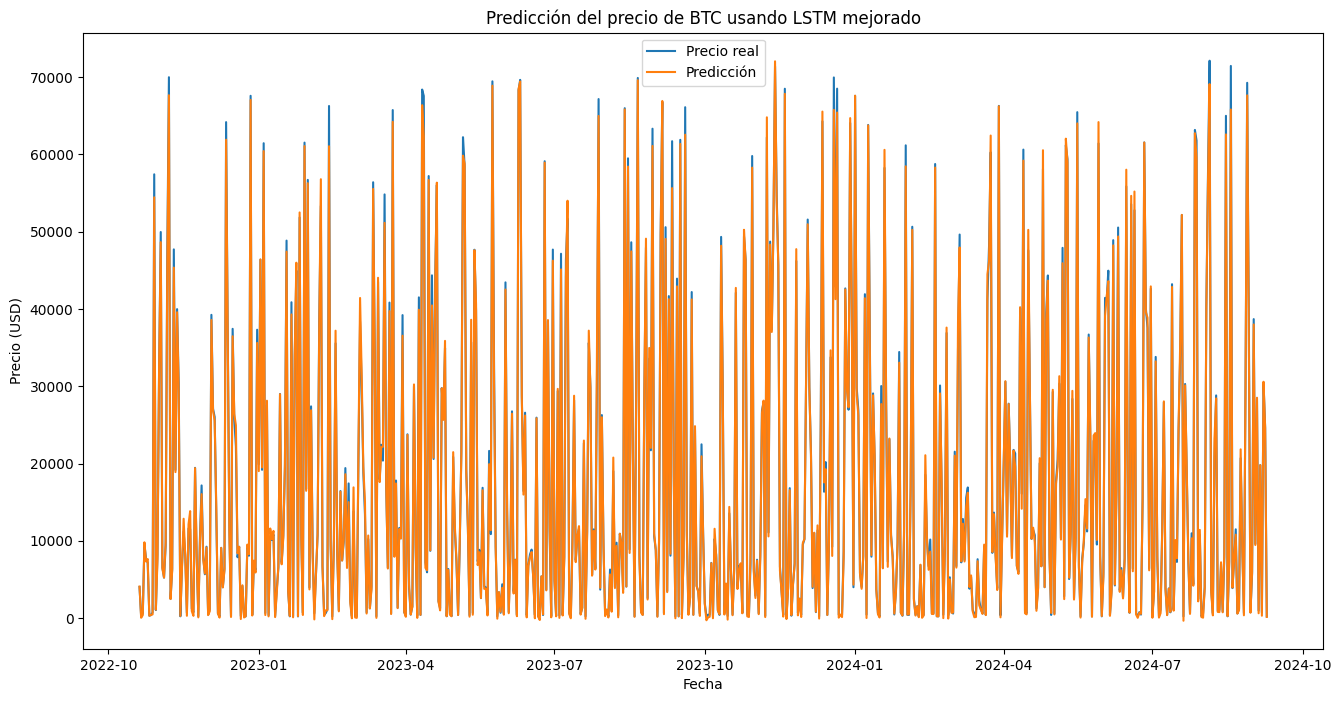

1/1 [==============================] - 0s 37ms/step
Predicción del precio de BTC para el próximo día: $55679.86


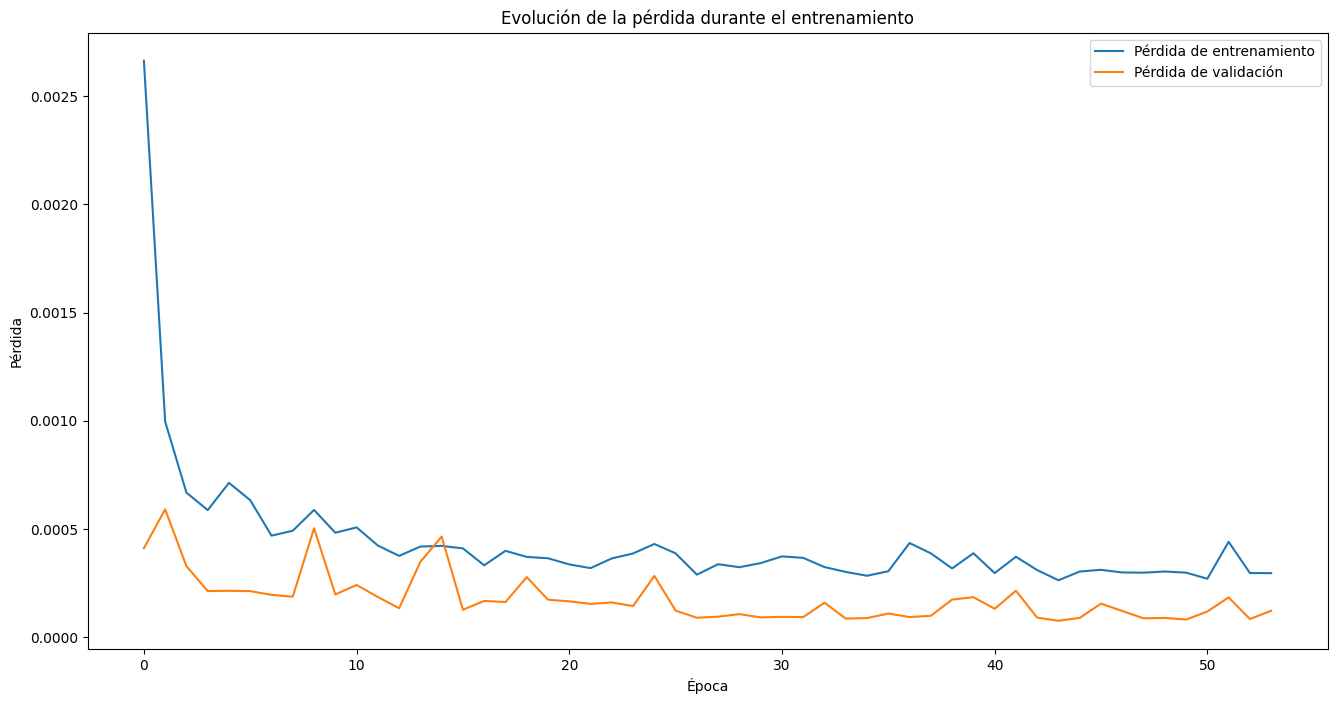

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import ta  # Asegúrate de que la biblioteca 'ta' esté instalada
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Función de pérdida personalizada
@tf.keras.saving.register_keras_serializable()
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    big_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, big_error_loss)

# Obtener datos históricos de BTC
btc_data = yf.download('BTC-USD', start='2015-01-01', end='2024-09-10')

# Procesamiento y Preparación de los Datos
df = btc_data[['Close', 'Volume', 'High', 'Low']].reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Agregar indicadores técnicos
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA30'] = df['Close'].rolling(window=30).mean()
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'].squeeze(), window=14).rsi()
df['MACD'] = ta.trend.MACD(df['Close'].squeeze()).macd()

# Eliminar filas con valores NaN
df = df.dropna()

# Normalización de los Datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close', 'Volume', 'High', 'Low', 'MA7', 'MA30', 'RSI', 'MACD']])

# Función para crear secuencias
@tf.keras.saving.register_keras_serializable()
def crear_secuencias(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Establecer el número de pasos temporales
time_steps = 60
X, y = crear_secuencias(scaled_data, time_steps)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo LSTM mejorado
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_steps, X.shape[2])),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=huber_loss)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=200,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Hacer predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir las predicciones a la escala original
train_predict = scaler.inverse_transform(np.hstack([train_predict, np.zeros((train_predict.shape[0], X.shape[2]-1))]))[:, 0]
test_predict = scaler.inverse_transform(np.hstack([test_predict, np.zeros((test_predict.shape[0], X.shape[2]-1))]))[:, 0]
y_train_inv = scaler.inverse_transform(np.hstack([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], X.shape[2]-1))]))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X.shape[2]-1))]))[:, 0]

# Calcular el error cuadrático medio (RMSE)
train_rmse = np.sqrt(np.mean((train_predict - y_train_inv)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test_inv)**2))

print(f"RMSE en entrenamiento: {train_rmse}")
print(f"RMSE en prueba: {test_rmse}")

# Visualizar los resultados
plt.figure(figsize=(16,8))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Precio real')
plt.plot(df.index[-len(y_test):], test_predict, label='Predicción')
plt.title('Predicción del precio de BTC usando LSTM mejorado')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

# Hacer una predicción para el próximo día
ultimo_60_dias = scaled_data[-60:]
X_siguiente = np.array([ultimo_60_dias])
prediccion_siguiente = model.predict(X_siguiente)
prediccion_siguiente = scaler.inverse_transform(np.hstack([prediccion_siguiente, np.zeros((prediccion_siguiente.shape[0], X.shape[2]-1))]))[:, 0]

print(f"Predicción del precio de BTC para el próximo día: ${prediccion_siguiente[0]:.2f}")

# Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
